#### **1. 导入模块**

导入 Python 标准库、第三方库和本项目自定义库

In [1]:
# 标准库
import os
import sys

# 第三方库
# pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# 将上级目录加入系统路径
# 以便导入项目自定义库
sys.path.append(os.path.abspath('..'))

# 自定义库
# 句法特征分析模块
from src.analyzer.syntax_feature_analysis import SyntaxFeatureAnalyzer

#### **2. 读取数据**

读取包含词性和句法标注的多版本平行语料库

In [2]:
# 指定语料库文件路径 data/output/1_syntax_annotation.jsonl
# 文件为 JSON 格式
# 包含译文的词性和句法特征标注

data_file = '../data/output/2_syntax_annotation.jsonl'
print(f"从 {os.path.abspath(data_file)} 文件读取数据 ...")

# 读取数据 
analyzer = SyntaxFeatureAnalyzer(data_file)
analyzer.load_and_count()
print(f"读取完成！包含下列版本：{analyzer.versions}\n")

# === PTB 英文词性赋码集 ===
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

# === UD 英文依存关系类别 ===
# https://universaldependencies.org/u/dep/

print("词性赋码和依存关系示例：")
ver = "human"
print(f'=== {ver} ===')
for feature_type, feature_distr in analyzer.stats[ver].items():
    if feature_type in ['pos', 'dep']:
        print(f"[{feature_type}]: {feature_distr}")

从 C:\llm_corpus_annotation_v3\data\output\2_syntax_annotation.jsonl 文件读取数据 ...
读取完成！包含下列版本：{'deepseek-v3.2', 'qwen3-max', 'human'}

词性赋码和依存关系示例：
=== human ===
[pos]: Counter({'IN': 980, 'NN': 935, 'DT': 885, 'PRP': 874, 'RB': 673, '.': 570, 'NNP': 565, 'VBD': 560, ',': 527, 'JJ': 481, 'VB': 464, 'NNS': 290, 'CC': 260, "''": 258, 'VBZ': 210, '``': 208, 'PRP$': 190, 'VBP': 182, 'TO': 181, 'MD': 178, 'VBG': 177, 'VBN': 168, 'POS': 81, 'CD': 68, 'RP': 64, 'WRB': 57, 'WP': 51, ':': 43, 'WDT': 28, 'UH': 27, 'EX': 23, 'RBR': 17, 'PDT': 16, 'NNPS': 16, 'JJR': 13, 'JJS': 9, '-LRB-': 4, '-RRB-': 4, 'RBS': 4, 'XX': 2, 'WP$': 1})
[dep]: Counter({'nsubj': 1016, 'case': 827, 'det': 822, 'advmod': 725, 'root': 573, 'obj': 525, 'obl': 448, 'amod': 389, 'mark': 388, 'aux': 340, 'cc': 260, 'nmod': 259, 'conj': 238, 'nmod:poss': 229, 'compound': 225, 'ccomp': 223, 'advcl': 218, 'cop': 206, 'xcomp': 196, 'dep': 129, 'acl:relcl': 60, 'acl': 57, 'aux:pass': 56, 'compound:prt': 55, 'nummod': 41, 'parataxis':

#### **3. 分析数据**

统计各版本译文中的词性和句法特征分布

In [3]:
# ==== 词性赋码分布 ====

# 指定词类
# 每个词类可对应多个标签
pos_config = {
    "名词": ["NN", "NNS", "NNP", "NNPS"],
    "动词": ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],
    "形容词": ["JJ", "JJR", "JJS"],
    "代词": ["PRP", "PRP$"],
    "介词": ["IN"],
}

# 统计指定词类占比
df_pos = analyzer.get_feature_report(
    feature_type='pos', 
    target_tags=pos_config,
)

# 预览统计结果
df_pos[df_pos["Feature Label"] == "名词"]

,Version,Feature Label,Count,Percentage
0,deepseek-v3.2,名词,2030,21.352687
5,qwen3-max,名词,2004,20.964536
10,human,名词,1806,17.459397


In [4]:
# === 句法关系分布 ===

# 指定句法结构
# 每个结构可对应多个标签
dep_config = {
    "被动语态": ["nsubj:pass", "csubj:pass", "aux:pass"],
    "复合名词结构": ["compound", "flat"],
    "从句结构 ": ["advcl", "ccomp", "acl"],
    "并列结构": ["conj", "cc"],
    "定语结构": ["amod", "advmod"]
}

# 统计指定结构占比
df_dep = analyzer.get_feature_report(
    feature_type='dep', 
    target_tags=dep_config,
)

# 预览统计结果
df_dep[df_dep["Feature Label"] == "并列结构"]

,Version,Feature Label,Count,Percentage
3,deepseek-v3.2,并列结构,613,7.637678
8,qwen3-max,并列结构,659,8.158970
13,human,并列结构,498,5.689478


#### **4. 绘制图表**

绘制柱状图，展示各译本中的词性/句法特征分布

In [5]:
# 设置绘图风格
font_name = 'Microsoft YaHei'
sns.set_theme(style="white", font=font_name) 

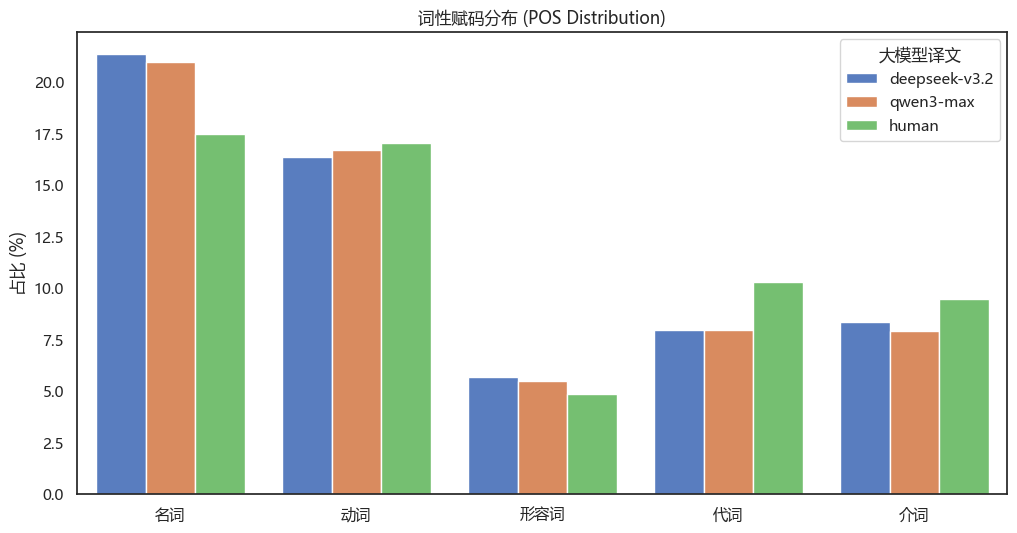

In [6]:
# --- 图 1: 词性赋码分布 ---
plt.figure(figsize=(12, 6))
sns.barplot(x="Feature Label", y="Percentage", hue="Version", data=df_pos, palette="muted")
plt.title("词性赋码分布 (POS Distribution)")
plt.xlabel("")
plt.ylabel("占比 (%)")
plt.legend(title="大模型译文")
plt.show()

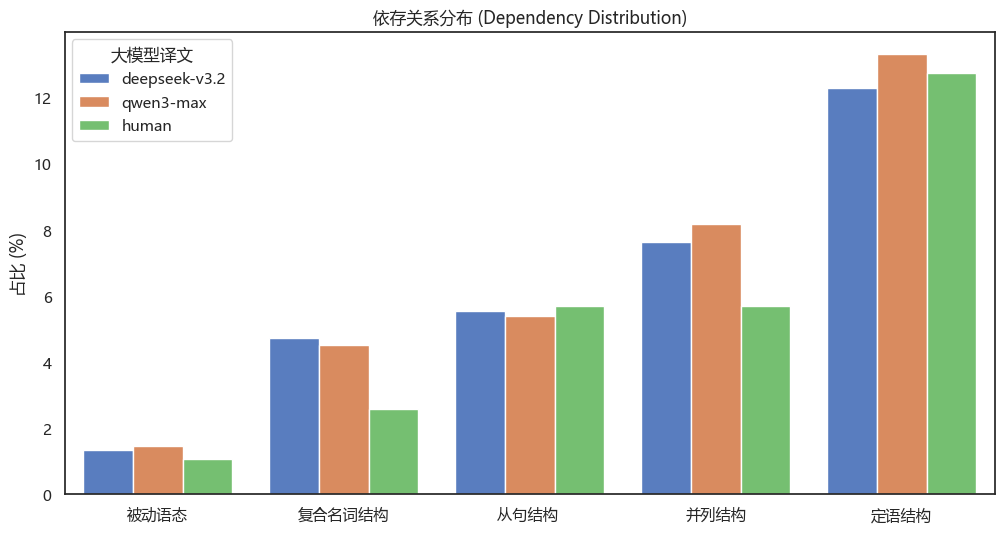

In [7]:
# --- 图 2: 句法关系分布 ---
plt.figure(figsize=(12, 6))
sns.barplot(x="Feature Label", y="Percentage", hue="Version", data=df_dep, palette="muted")
plt.title("依存关系分布 (Dependency Distribution)")
plt.xlabel("")
plt.ylabel("占比 (%)")
plt.legend(title="大模型译文")
plt.show()

#### **5. 提取例句**

提取机器译文和人工译文之间句法特征差异最大的例句

In [8]:
# 指定译文版本
# 版本 A (ver_a): 数量多
# 版本 B (ver_b): 数量少
ver_a = "deepseek-v3.2"
ver_b = "human"

# 指定特征类别
# pos：词性特征
# dep：为句法特征
feature_type = 'pos'

# 指定具体词性
target_tags= ["NN", "NNS", "NNP", "NNPS"]

In [9]:
# --- 提取词性特征差异最大的例句 ---

# 提取例句
examples = analyzer.get_examples(
    data_file,
    feature_type=feature_type,
    target_tags=target_tags, 
    ver_a=ver_a,
    ver_b=ver_b,
)

# 打印例句
print(f"\n共找到 {len(examples)} 个典型案例")
analyzer.print_examples(examples, target_tags, ver_a, ver_b) 


共找到 110 个典型案例

=== ['NN', 'NNS', 'NNP', 'NNPS'] 差异最大的例句 Top 3 ===

[1] ID: 000242 (Diff: +14)
[source]: 韦小宝寻思：“你沐王府在江湖上好大威风，那日苏北道上，你家那白寒松好大架子，丝毫没将老子瞧在眼里，这当儿还不是让我手下的人打死了。 他奶奶的……” 想到此处，伸起手来，见手腕上黑黑一圈乌青兀自未退，隐隐还感疼痛，心道：“那白寒枫死了哥哥，没处出气，捏得老子骨头也险些断了。
------------------------------------------------------------
[deepseek-v3.2] (Count: 27):
Text: Wei Xiaobao thought to himself, "Your Mu Prince's Mansion has such a formidable reputation in the martial world. That day on the road in northern Jiangsu, your Bai Hansong put on such airs, not giving me the slightest regard. And now, he's been killed by my men. Damn it all..." At this point, he raised his hand and saw that the dark circle of bruising around his wrist had still not faded, with a faint lingering pain. He thought, "That Bai Hanfeng, having lost his brother and with nowhere to vent his anger, nearly crushed my bones."
Keywords: ['Wei(NNP)', 'Xiaobao(NNP)', 'Mu(NNP)', 'Prince(NNP)', 'Mansion(NNP)', 'reputation(NN)', 'world(NN)', 'day(NN)', '

In [10]:
# 指定译文版本
# 版本 A (ver_a): 数量多
# 版本 B (ver_b): 数量少
ver_a = "deepseek-v3.2"
ver_b = "human"

# 指定特征类别
# pos：词性特征
# dep：为句法特征
feature_type = 'dep'

# 指定具体结构
target_tags= ["conj", "cc"]

In [11]:
# --- 提取词性特征差异最大的例句 ---

# 提取例句
examples = analyzer.get_examples(
    data_file,
    feature_type=feature_type,
    target_tags=target_tags, 
    ver_a=ver_a,
    ver_b=ver_b,
)

# 打印例句
print(f"\n共找到 {len(examples)} 个典型案例")
analyzer.print_examples(examples, target_tags, ver_a, ver_b) 


共找到 83 个典型案例

=== ['conj', 'cc'] 差异最大的例句 Top 3 ===

[1] ID: 000055 (Diff: +9)
[source]: 他眼见黄顾二人脸色凝重，又知顾炎武向来极富机变，临事镇定，既说是要紧事，自然非同小可， 拱手道：“两位请进去先喝三杯，解解寒气。”
------------------------------------------------------------
[deepseek-v3.2] (Count: 11):
Text: Seeing the grave expressions on Huang and Gu's faces, and knowing that Gu Yanwu was always resourceful and composed in the face of events, he realized that if Gu described it as an urgent matter, it must indeed be of great importance. He cupped his hands and said, "Please, both of you, come inside first and have three cups of wine to ward off the chill."
Keywords: ['and(cc)', 'Gu(conj)', "'(conj)", 'and(cc)', 'knowing(conj)', 'and(cc)', 'composed(conj)', 'and(cc)', 'said(conj)', 'and(cc)', 'have(conj)']
------------------------------------------------------------
[human] (Count: 2):
Text: Lü Liuliang observed the grave expression on his visitors' faces. Knowing of old how unfailingly Gu Yanwu's political judgement was to be trusted, he rea